In [62]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from skyburst import Job
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

def load_logs(file_path: str):
    file = open(file_path)
    return pickle.load(file)

In [20]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'size': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    for key, finished_jobs in simulator_results.items():
        alg, num_nodes = key.split('-')
        num_nodes = int(num_nodes)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        for j in finished_jobs:
            if j.start is None:
                cloud_cost += j.cost
                if hasattr(j, 'state') and j.state == 'FILTER-CLOUD':
                    pass
                else:
                    total_waiting_time += j.deadline - j.runtime - j.arrival
            else:
                total_waiting_time += j.start - j.arrival
        avg_waiting_time = total_waiting_time / len(finished_jobs)
        df = pd.DataFrame(data={'alg': [alg], 'size': [num_nodes], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_waiting_cost_graph(results_df, title=None):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
        a2 = grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()  

0


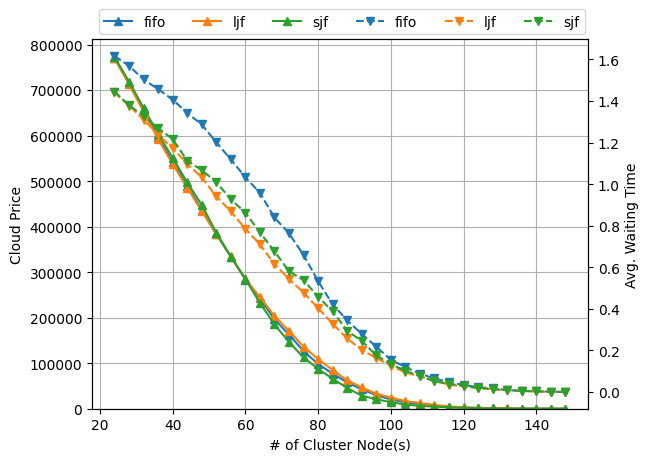

0.1


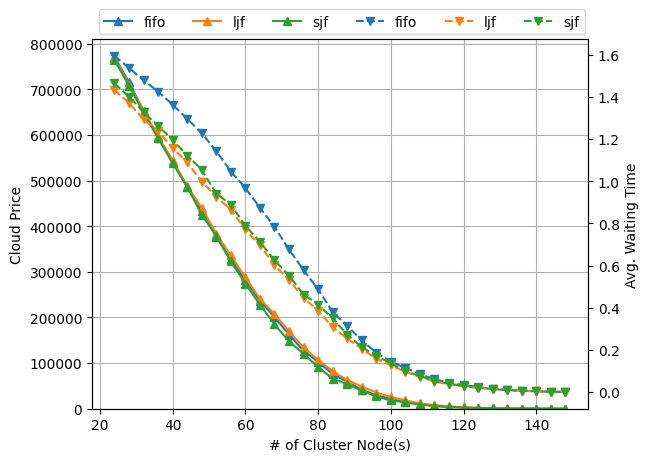

0.125


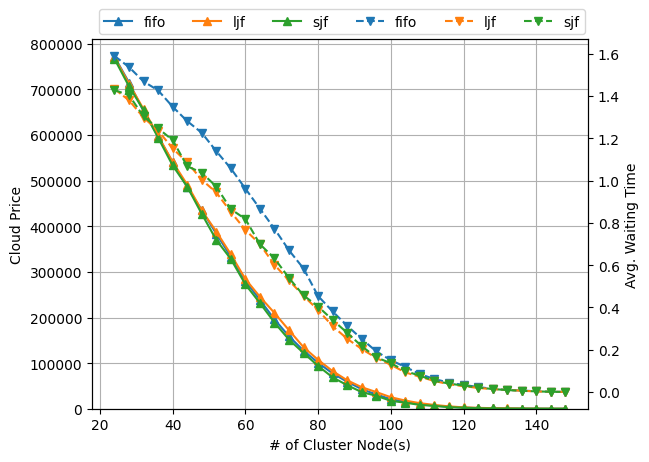

0.2


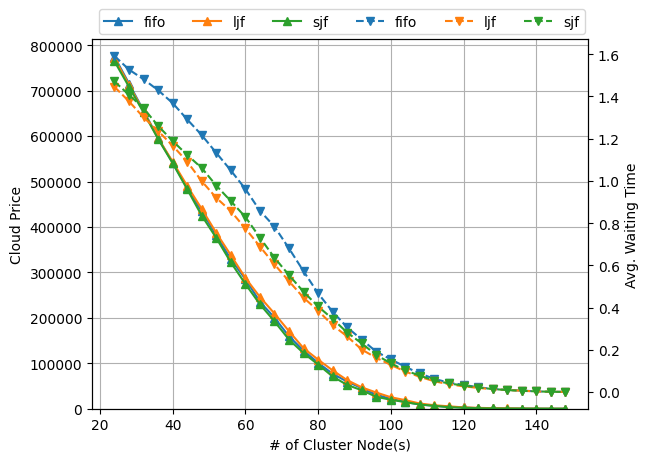

0.5


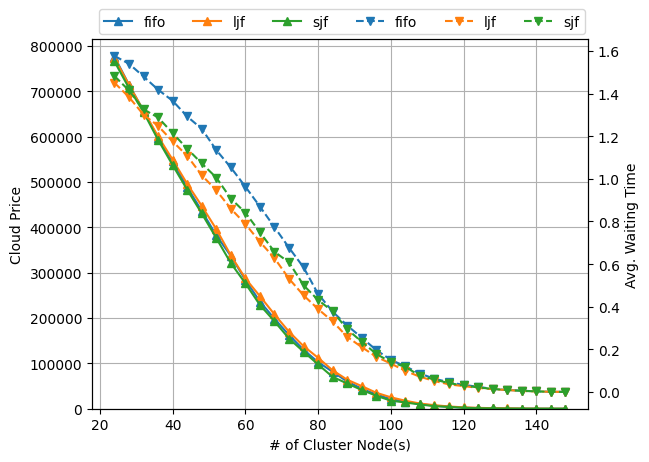

In [21]:
hybrid_results = {}
hybrid_results_df = pd.DataFrame()
for thres in [0, 0.1, 0.125, 0.2, 0.5]:
    print(thres)
    if thres==0:
        file = open(f'logs/vjw_philly_1.5_cont.log', 'rb')
    else:
        file = open(f'logs/vjw_philly_1.5_preempt_{thres}_cont.log', 'rb')
    hybrid_results[thres] = pickle.load(file)
    temp_df = create_results_df(hybrid_results[thres])
    temp_df['thres'] = thres
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)
    plot_waiting_cost_graph(temp_df)

fifo


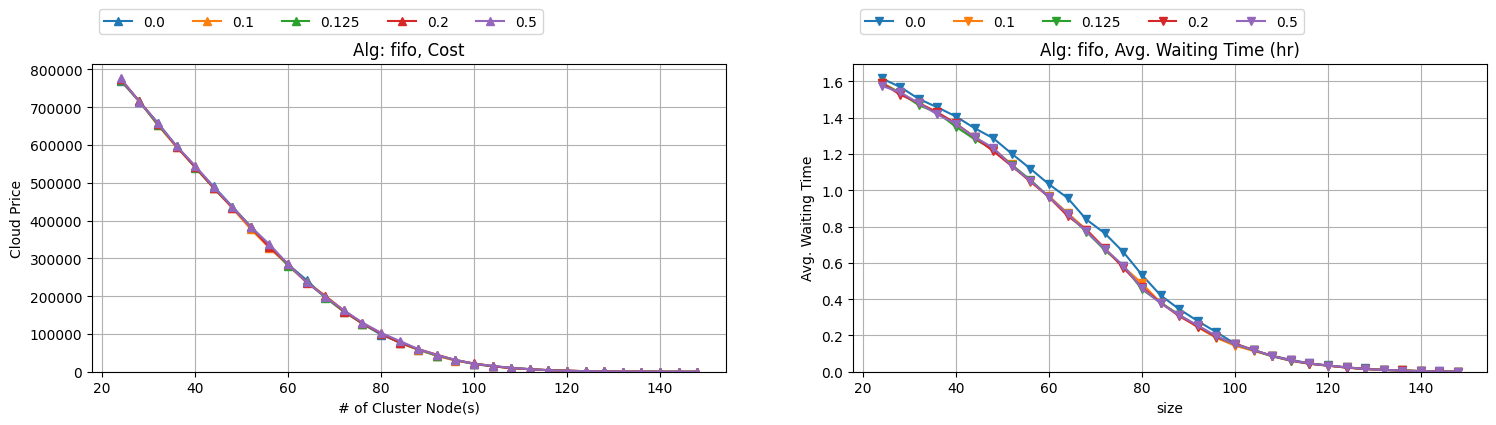

ljf


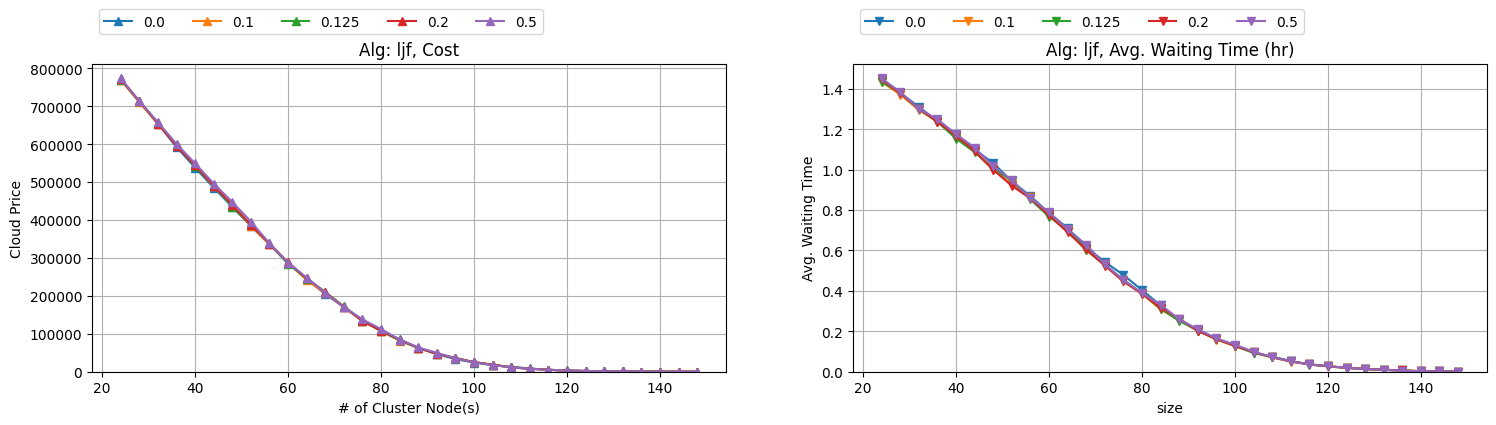

sjf


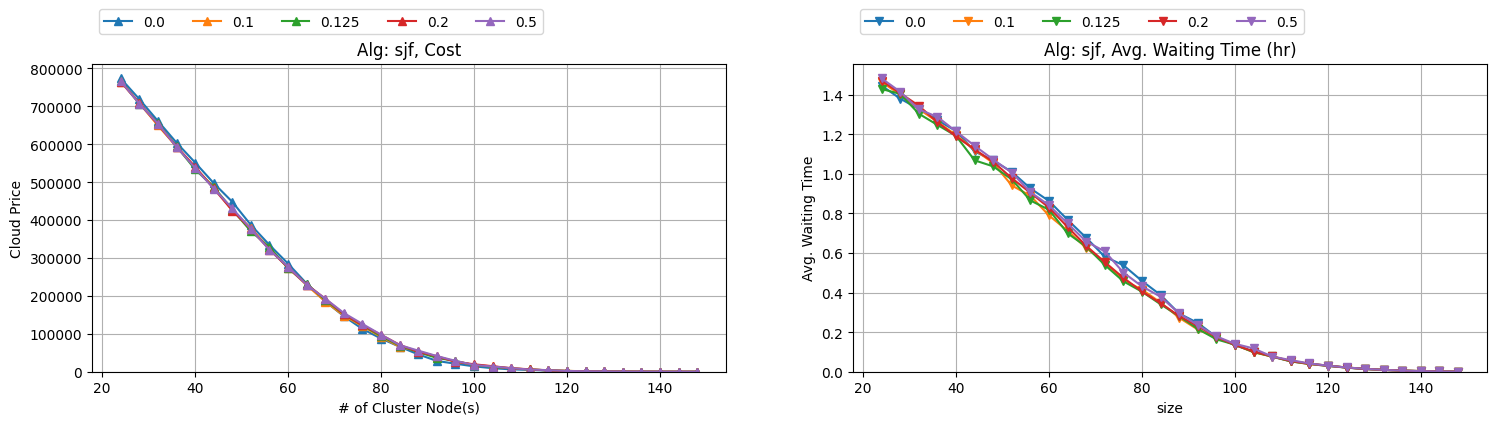

In [22]:
def plot_waiting_cost_graph_diff_deadline(results_df, alg='ljf', title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18.0, 4.0])
    results_df = results_df[results_df['alg'] == alg]
    for idx, (label, grp) in enumerate(results_df.groupby('thres')):
        grp.plot(x = 'size', y = 'cost',ax = ax1, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
        grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time')
    ax1.set_ylim(bottom=0.0)
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax1.grid(True, which='both')
    ax1.set_title(f'Alg: {alg}, Cost')
    
    ax2.set_ylim(bottom=0.0)
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax2.grid(True, which='both')
    ax2.set_title(f'Alg: {alg}, Avg. Waiting Time (hr)')
    plt.show()
for alg in ['fifo', 'ljf', 'sjf']:
    print(alg)
    plot_waiting_cost_graph_diff_deadline(hybrid_results_df, alg=alg)

fifo


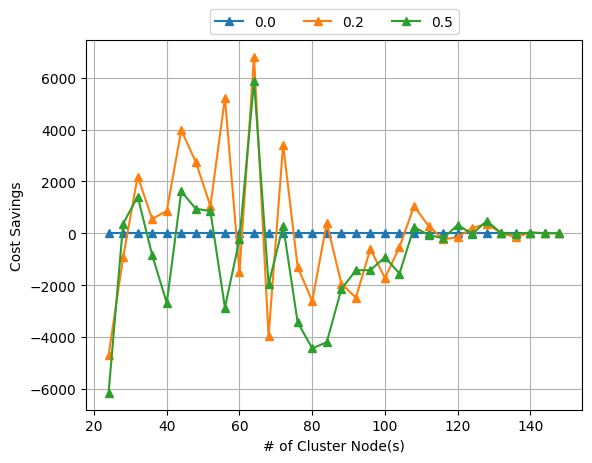

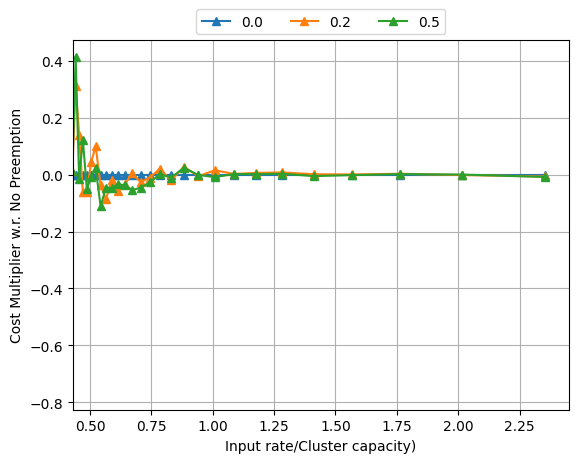

ljf


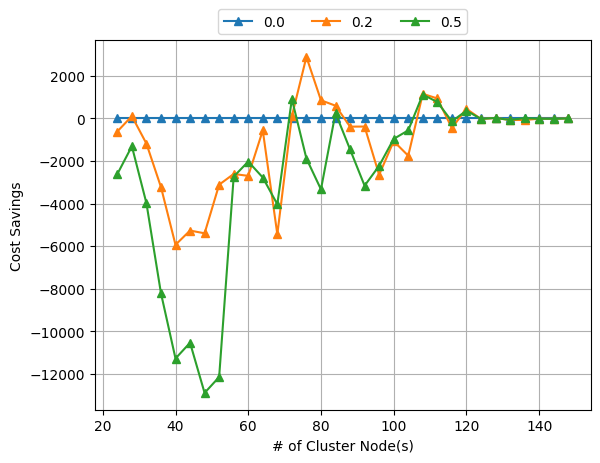

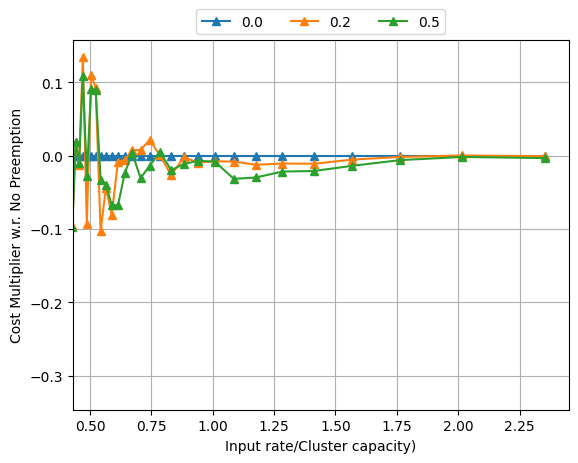

sjf


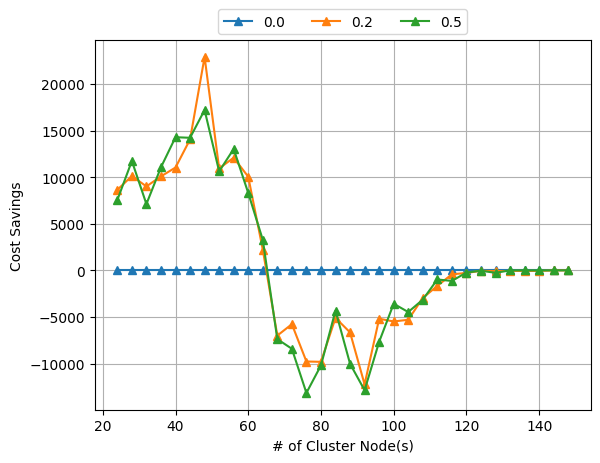

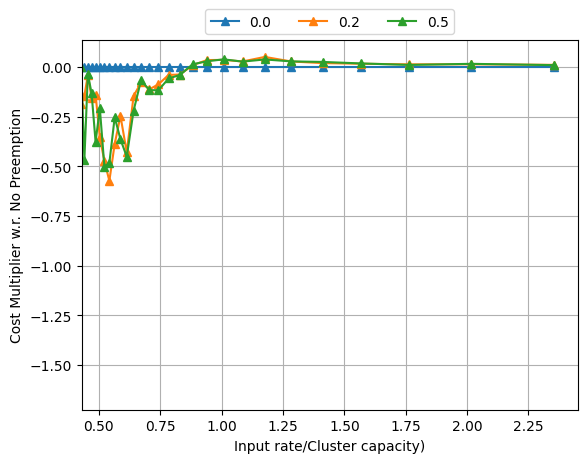

In [53]:
def plot_cost_diff_deadline(results_df, alg='fifo', normalize=False, title=None):
    fig, ax = plt.subplots()
    asdf = results_df[results_df['alg'] == alg]
    options = [0, 0.5, 0.2]
    lol = asdf[asdf['thres'].isin(options)]
    one_df = asdf[asdf['thres'] == 0] 
    diff_df = pd.merge(one_df,
               lol, left_on=['alg', 'size'],right_on=['alg', 'size'])
    
    if normalize:
        total_job_gpu_hours = 1155998.77277777
        job_makespan = 2559.3205555555555
        diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])/diff_df['cost_x']
        diff_df['x_axis'] = total_job_gpu_hours/(job_makespan*diff_df['size']*8)
        label_y = 'Cost Multiplier w.r. No Preemption'
        label_x = 'Input rate/Cluster capacity)'
    else:
        diff_df['cost_diff'] = diff_df['cost_x'] - diff_df['cost_y']
        diff_df['x_axis'] = diff_df['size']
        label_y = 'Cost Savings'
        label_x = '# of Cluster Node(s)'

    for idx, (label, grp) in enumerate(diff_df.groupby('thres_y')):
        a1 = grp.plot(x = 'x_axis', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel=label_y)
    lines, labels = ax.get_legend_handles_labels()
    if normalize:
        plt.xlim(left=0.43)
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.95, 1, 0.2), loc="center")
    ax.grid(True, which='both')
    plt.show()

for alg in ['fifo', 'ljf', 'sjf']:
    print(alg)
    plot_cost_diff_deadline(hybrid_results_df, alg=alg)
    plot_cost_diff_deadline(hybrid_results_df, alg=alg, normalize=True)

/tmp/ipykernel_23620/2540476402.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[x_axis] = total_job_gpu_hours/(job_makespan*results_df['size']*8)


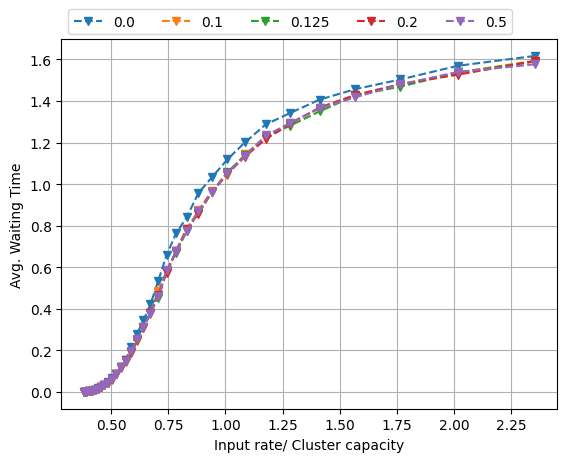

In [59]:

def plot_waiting_cost_graph(results_df, alg='fifo', normalized=False, title=None):
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg']==alg]
    #ax2 = ax.twinx()
    if normalized:
        x_axis = 'norm_size'
        label_x = 'Input rate/ Cluster capacity'
        total_job_gpu_hours = 1155998.77277777
        job_makespan = 2559.3205555555555
        results_df[x_axis] = total_job_gpu_hours/(job_makespan*results_df['size']*8)
    else:
        x_axis = 'size'
        label_x = '# of Cluster Node(s)'
    
    for idx, (label, grp) in enumerate(results_df.groupby('thres')):
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax, marker='v', label = label, legend=None, xlabel = 'Input rate/ Cluster capacity', \
                      ylabel = 'Avg. Waiting Time', style='--')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show() 


plot_waiting_cost_graph(hybrid_results_df, normalized=True)

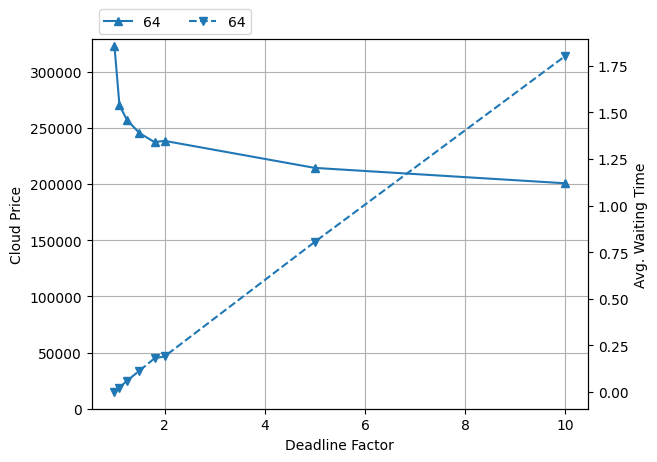

In [46]:
def plot_deadline_constant_nodes(results_df, num_nodes=96, alg='ljf'):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    results_df = results_df[results_df['size'] == num_nodes] 
    results_df = results_df[results_df['deadline'] != 100000] 
    #results_df = results_df[results_df['deadline'] != 1] 
    results_df = results_df[results_df['alg'] == alg] 
    for idx, (label, grp) in enumerate(results_df.groupby('size')):
        a1 = grp.plot(x = 'deadline', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='Deadline Factor', \
                ylabel='Cloud Price')
        a2 = grp.plot(x = 'deadline', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
              bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()

plot_deadline_constant_nodes(hybrid_results_df, num_nodes=64)

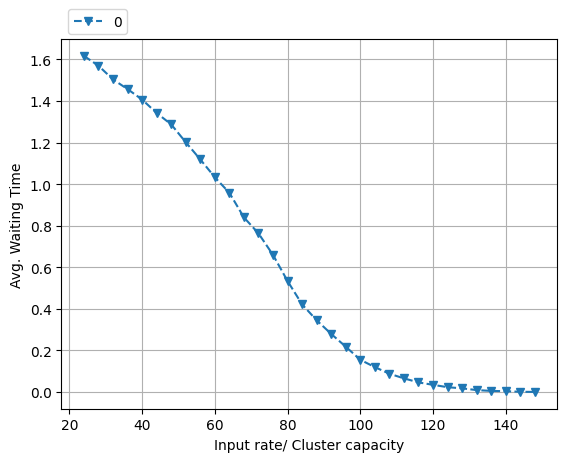

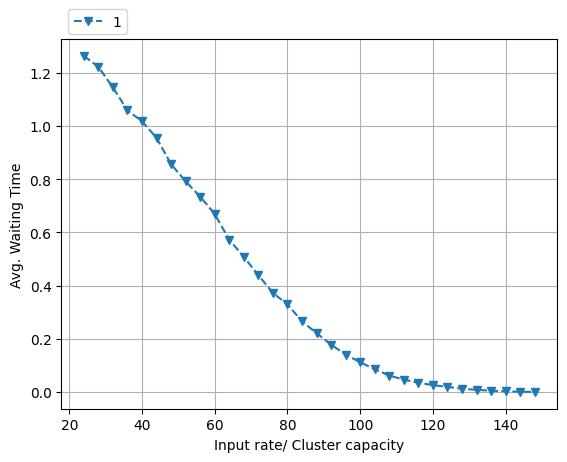

In [63]:
hybrid_results = {}
hybrid_results_df = pd.DataFrame()


file = open(f'logs/vjw_philly_1.5_cont.log', 'rb')

hybrid_results[0] = pickle.load(file)
temp_df = create_results_df(hybrid_results[0])
temp_df['thres'] = 0
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)
plot_waiting_cost_graph(temp_df)

file = open(f'logs/vjw_philly_1.5_asdf_cont.log', 'rb')

hybrid_results[1] = pickle.load(file)
temp_df = create_results_df(hybrid_results[1])
temp_df['thres'] = 1
hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)
plot_waiting_cost_graph(temp_df)

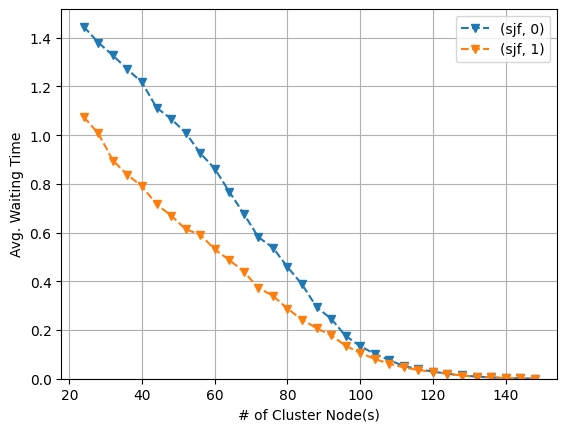

/tmp/ipykernel_23620/2877777317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['norm_size'] = total_job_gpu_hours/(job_makespan*results_df['size']*8)


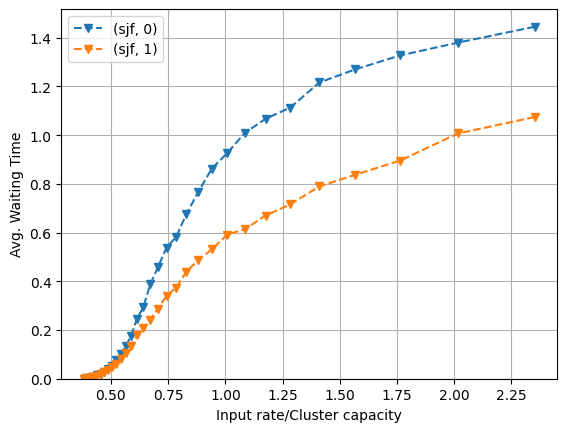

In [74]:
def plot_waiting_cost_graph(results_df, normalize=False, title=None):
    results_df = results_df[results_df['alg']=='sjf']
    fig, ax = plt.subplots()
#     ax2 = ax.twinx()
    if normalize:
        total_job_gpu_hours = 1155998.77277777
        job_makespan = 2559.3205555555555
        results_df['norm_size'] = total_job_gpu_hours/(job_makespan*results_df['size']*8)
        x_axis ='norm_size'
        label_x = 'Input rate/Cluster capacity'
    else:
        x_axis = 'size'
        label_x = '# of Cluster Node(s)'


    for idx, (label, grp) in enumerate(results_df.groupby(['alg', 'thres'])):
#         a1 = grp.plot(x = 'size', y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
#                 ylabel='Cloud Price')
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax, marker='v', label = label, legend=None, xlabel=label_x, ylabel = 'Avg. Waiting Time', style='--')
    ax.set_ylim(bottom=0.0)
    ax.legend()
    
    lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
#     ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
#               bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
    ax.grid(True, which='both')
    plt.show()  

plot_waiting_cost_graph(hybrid_results_df)
plot_waiting_cost_graph(hybrid_results_df, normalize=True)

fifo


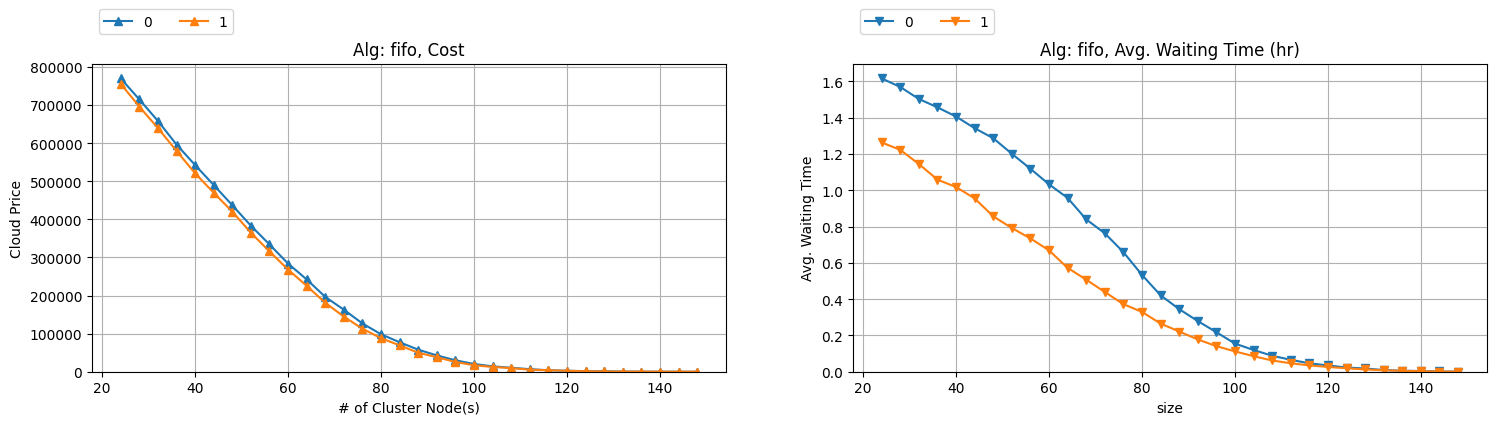

ljf


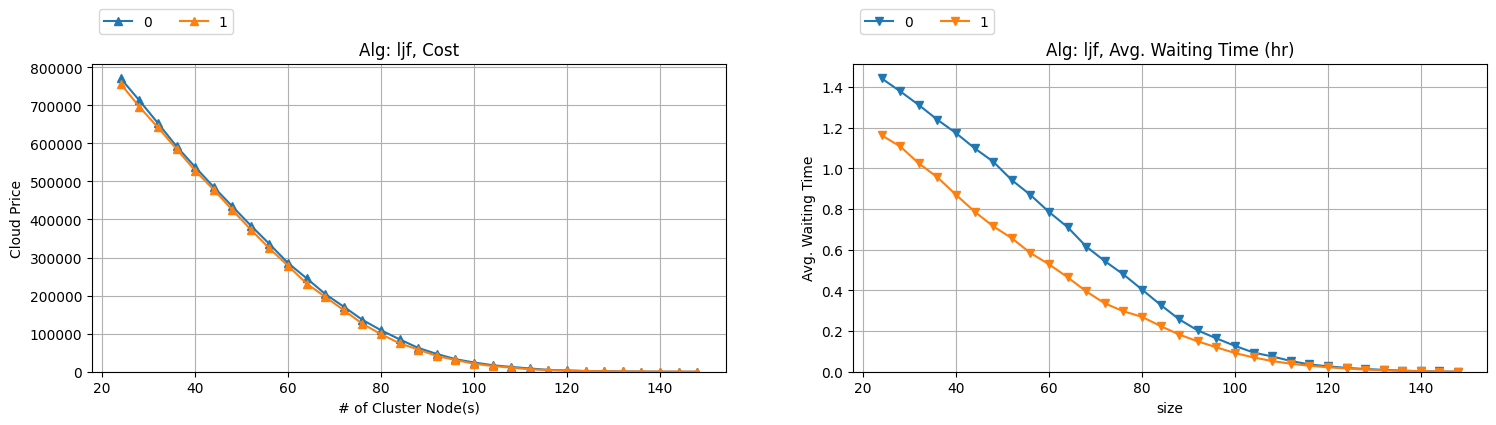

sjf


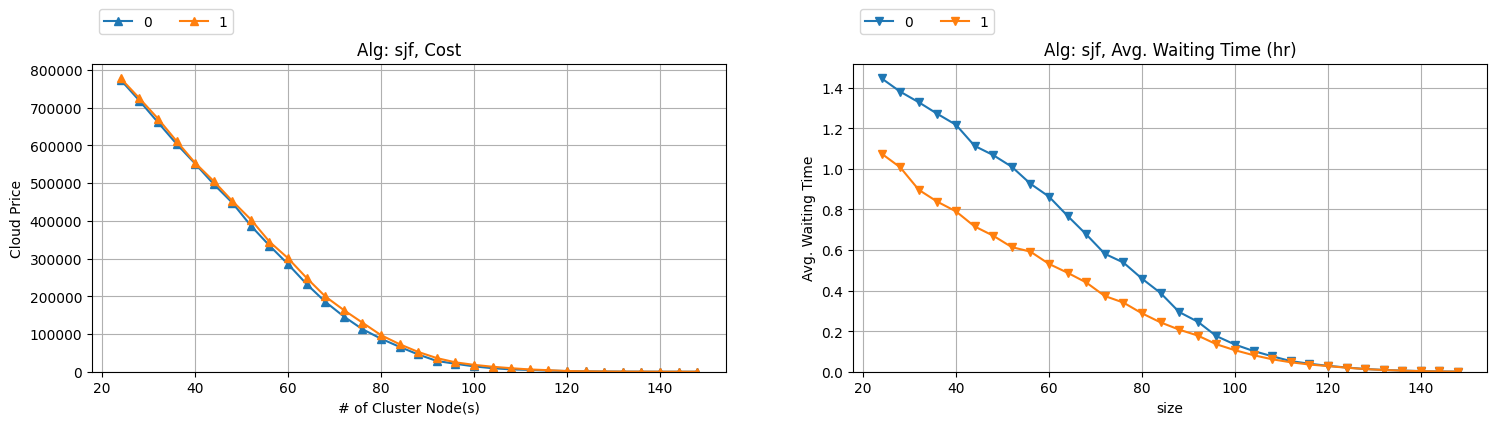

In [79]:
def plot_waiting_cost_graph_diff_deadline(results_df, alg='ljf', title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[18.0, 4.0])
    results_df = results_df[results_df['alg'] == alg]
    for idx, (label, grp) in enumerate(results_df.groupby('thres')):
        grp.plot(x = 'size', y = 'cost',ax = ax1, marker='^', label = label, legend=None, xlabel='# of Cluster Node(s)', \
                ylabel='Cloud Price')
        grp.plot(x = 'size', y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, ylabel = 'Avg. Waiting Time')
    ax1.set_ylim(bottom=0.0)
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax1.grid(True, which='both')
    ax1.set_title(f'Alg: {alg}, Cost')
    
    ax2.set_ylim(bottom=0.0)
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 1.0, 1, 0.2), loc="upper left")
    ax2.grid(True, which='both')
    ax2.set_title(f'Alg: {alg}, Avg. Waiting Time (hr)')
    plt.show()
    
    
for alg in ['fifo', 'ljf', 'sjf']:
    print(alg)
    plot_waiting_cost_graph_diff_deadline(hybrid_results_df, alg=alg)

fifo


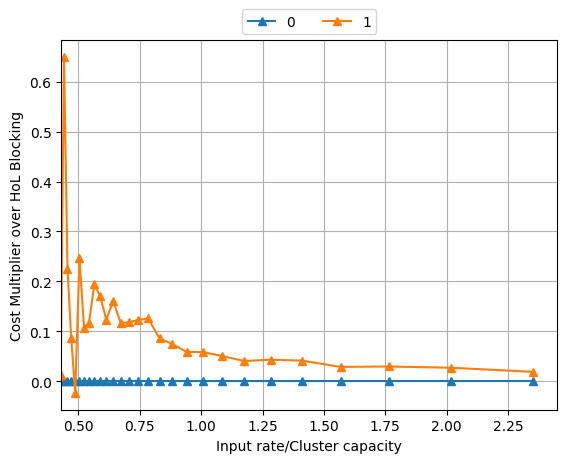

ljf


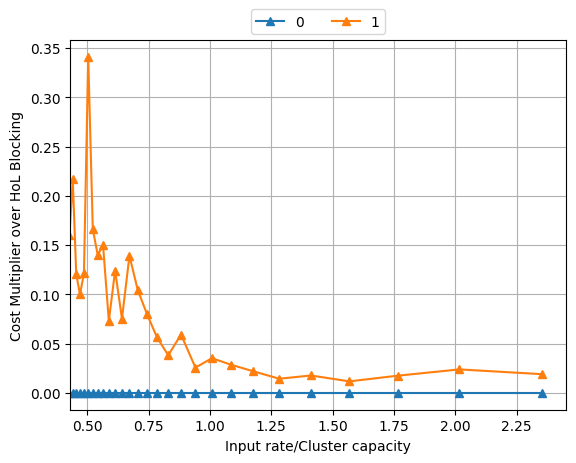

sjf


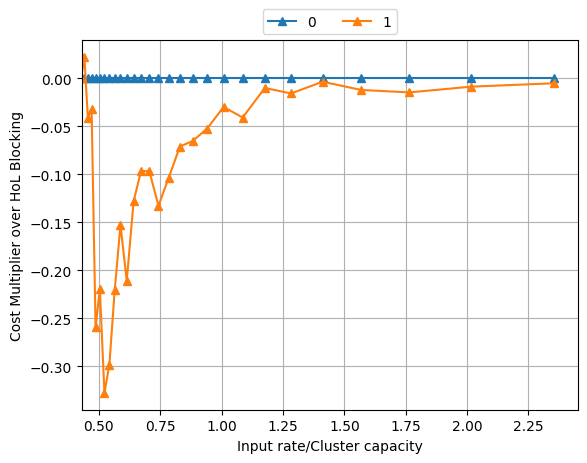

In [82]:
def plot_cost_diff_deadline(results_df, alg='ljf', normalize=False, title=None):
    fig, ax = plt.subplots()
    results_df = results_df[results_df['alg'] == alg]
    one_df = results_df[results_df['thres'] == 0] 
    diff_df = pd.merge(one_df,
               results_df, left_on=['alg', 'size'],right_on=['alg', 'size'])
    diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])/diff_df['cost_y']

    if normalize:
        total_job_gpu_hours = 1155998.77277777
        job_makespan = 2559.3205555555555
        diff_df['x_axis'] = total_job_gpu_hours/(job_makespan*diff_df['size']*8)
        diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])/diff_df['cost_y']
        label_x = 'Input rate/Cluster capacity'
        label_y = 'Cost Multiplier over HoL Blocking'
    else:
        label_x = '# of Cluster Node(s)'
        diff_df['x_axis'] = diff_df['size']
        diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])
        label_y = 'Cost Savings'
    for idx, (label, grp) in enumerate(diff_df.groupby('thres_y')):
        a1 = grp.plot(x = 'x_axis', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel=label_y)
    if normalize:
        ax.set_xlim(left=0.43)
    #ax.set_ylim(bottom=0.0)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.95, 1, 0.2), loc="center")
    ax.grid(True, which='both')
    plt.show()

for alg in ['fifo', 'ljf', 'sjf']:
    print(alg)
    plot_cost_diff_deadline(hybrid_results_df, alg=alg, normalize=True)

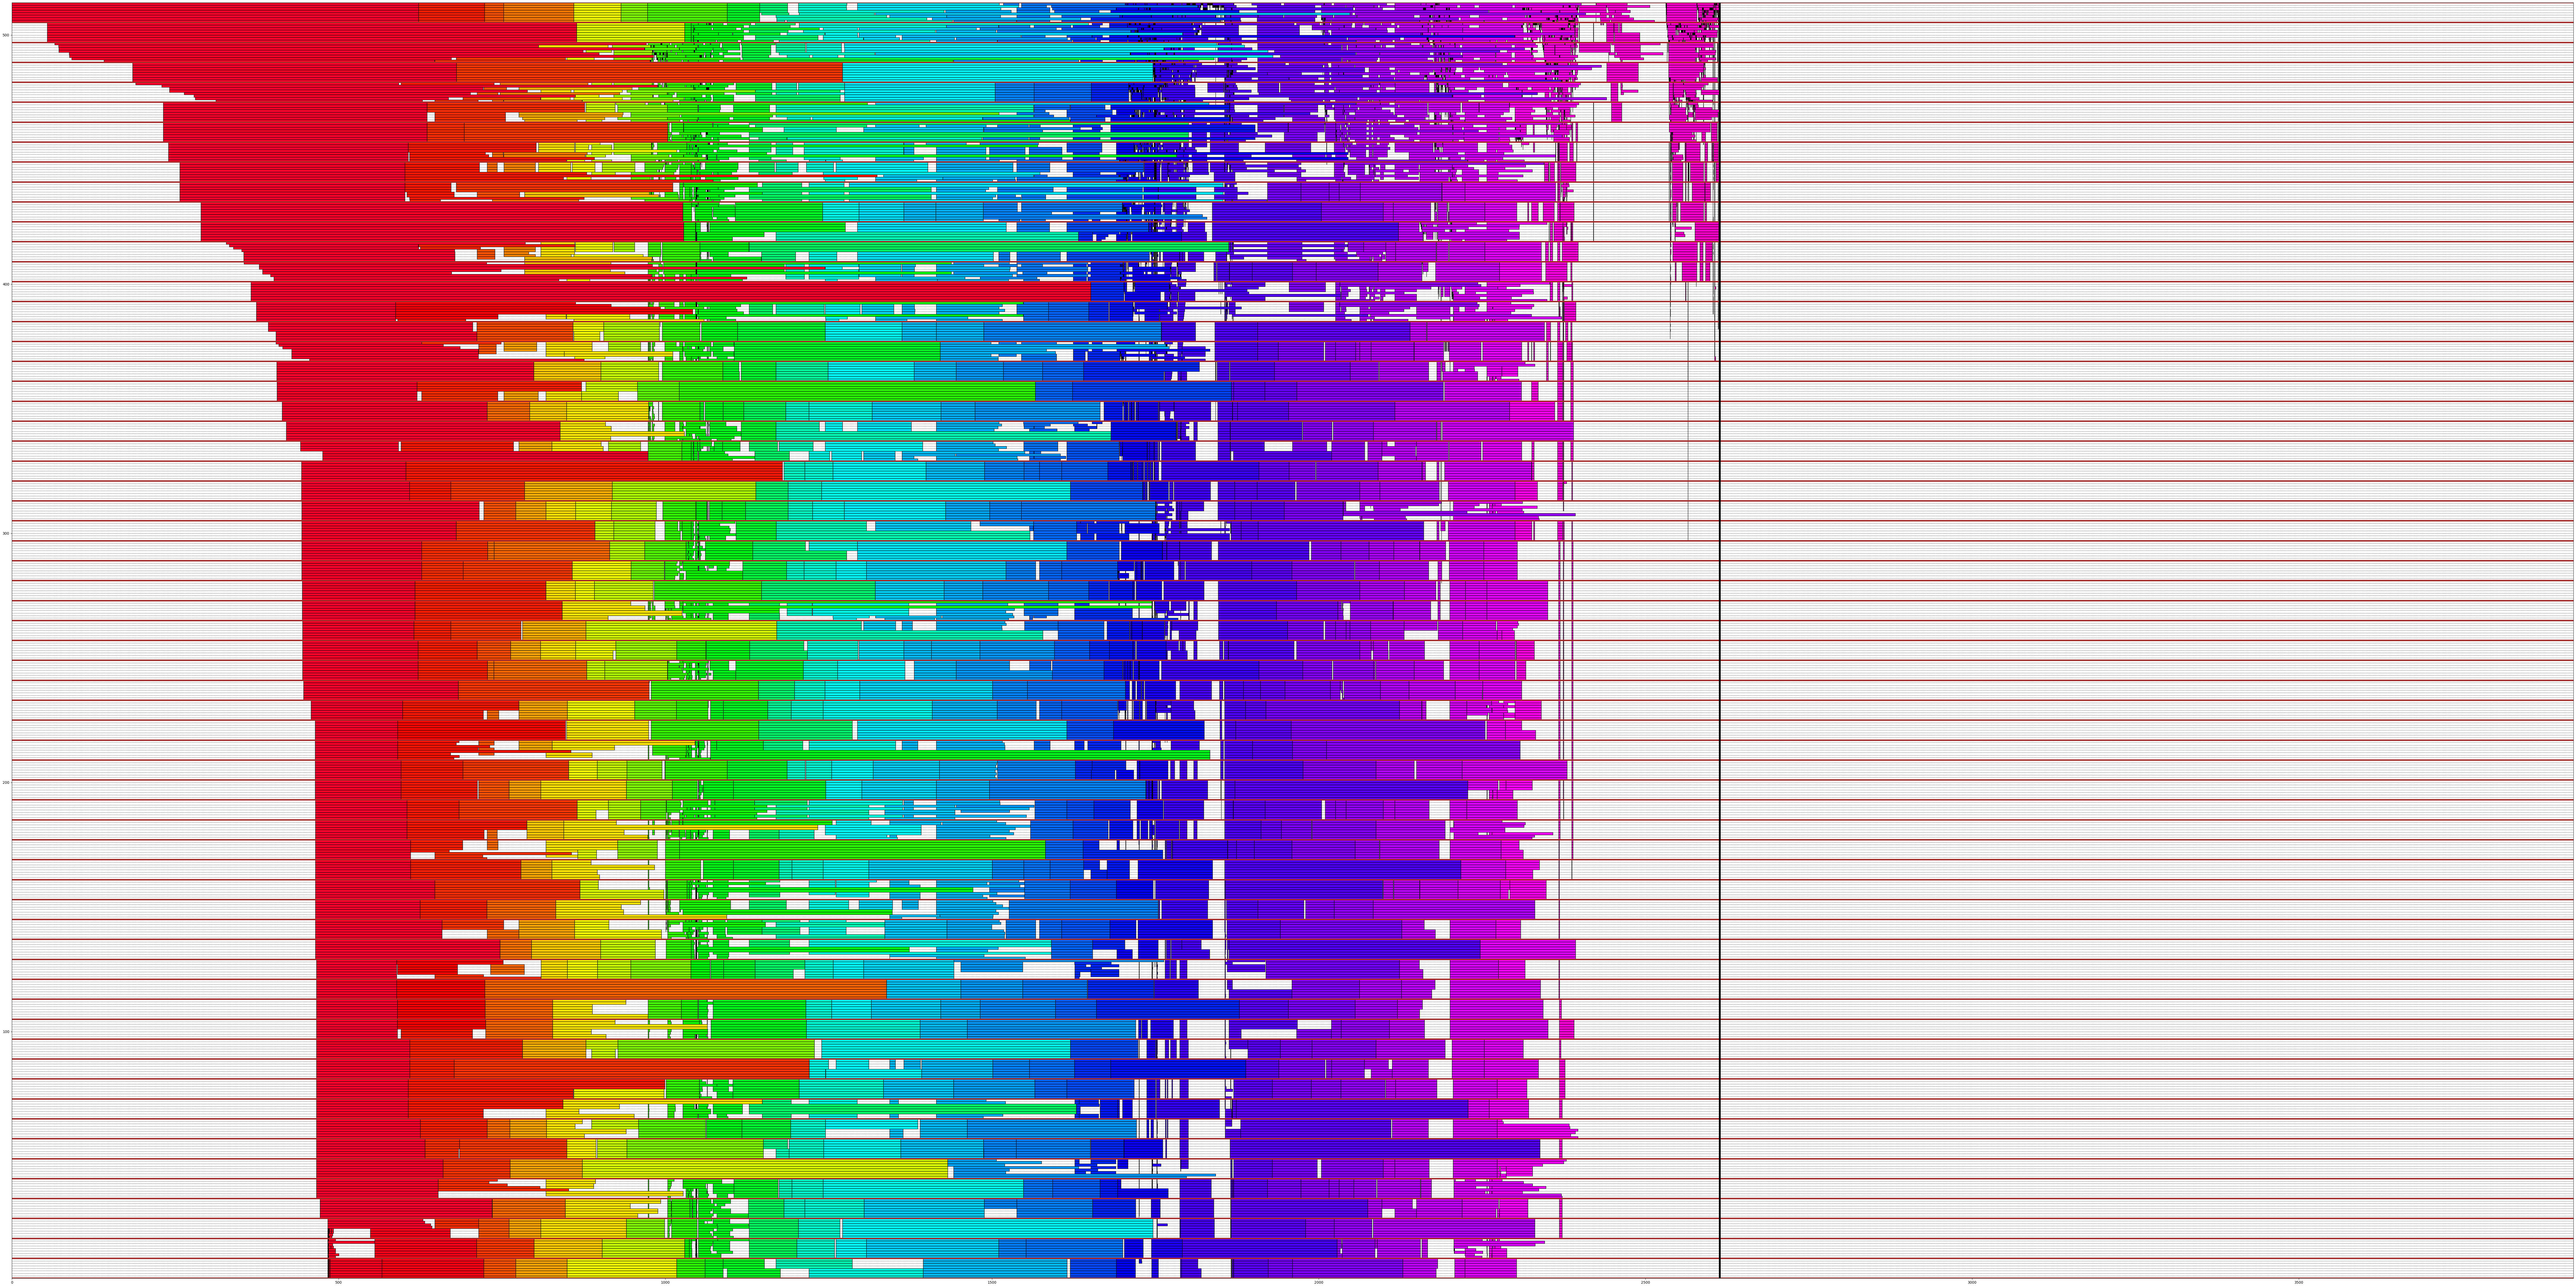

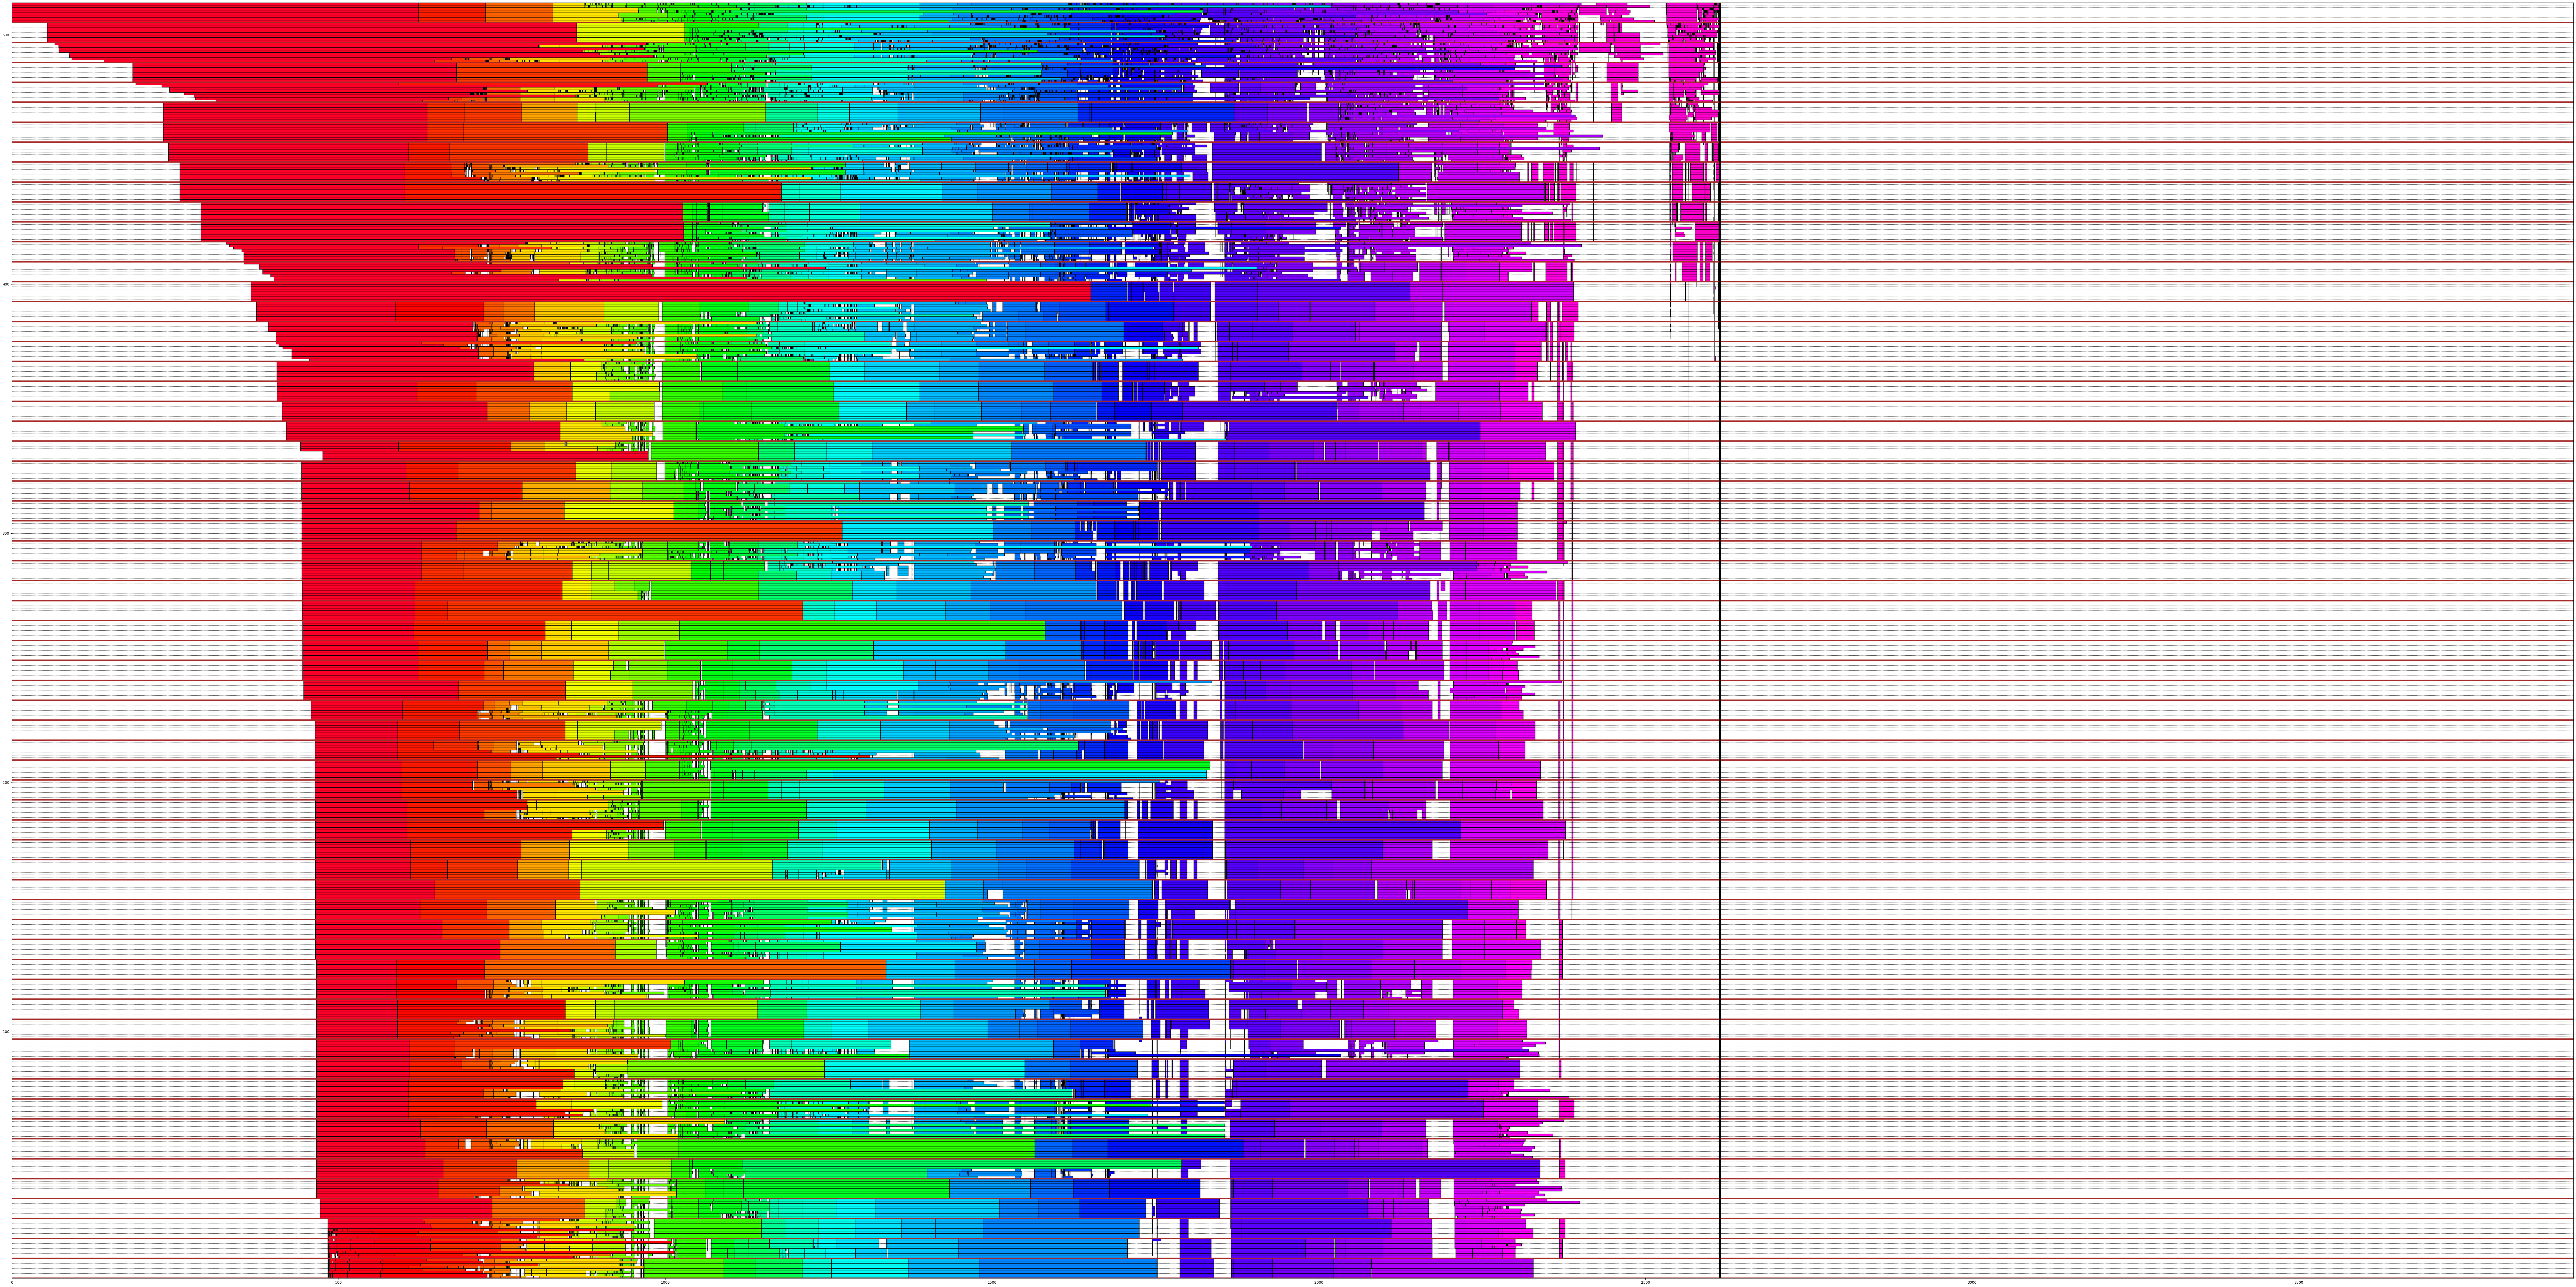

In [12]:
from skyburst.plot import *

plot_trace_spacetime(hybrid_results[0]['fifo-64'], 64)

plot_trace_spacetime(hybrid_results[1]['fifo-64'], 64)